<a href="https://colab.research.google.com/github/TariqMBrown/CIVICs/blob/main/TrexCompanion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello User, The following code is intended to be used as a companion to the TRex tracking software developed by [Walter and Couzin (2021)](https://https://trex.run/docs/). The output of that software generates a csv for individual objects being tracked, and for each frame that object is tracked it has metrics recorded such as "Velocity" or X/Y positions.

This code is specifically to be used with the Tandem Two-Choice assay, but can be modified to suit multiple types of assays.

The output of this code includes csvs that have preference index overall as well as over time, bout information, as well as average velocity, overall movement within particulat areas of the arena in which the objects are moving and more.

In order to use this code properly, ensure that your arena is properly represented so that the code can accurately determine which region of the arena the object is in.

The things you will want to change are:


*   Under Setup: change the parameters to match how your video was recorded
*   Under Setup: change the dimensions of the arena to match the location of points within your recording (e.g. make sure diagonal points 1 and 2 reside on the points within your recording, as well as origin location for the arena)
*   Under Individual File Processing: Make sure the filepaths are correct
*   Under Individual Batch Processing: Make sure the filepaths are correct

**IF THE CODE IS WORKING AS INTENDED, YOU WILL BE ABLE TO SEE THE TRACES PERFECTLY REPRESENT THE FLIES MOTION, AND IF IT CROSSES OVER THE LINE IN THE GRAPH THE COLOR SHOULD CHANGE FOR THE REGULAR TRACE GRAPH.**

Not working:

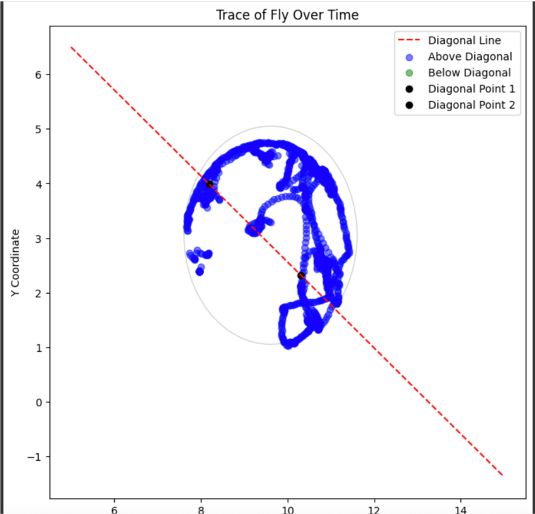

Working:


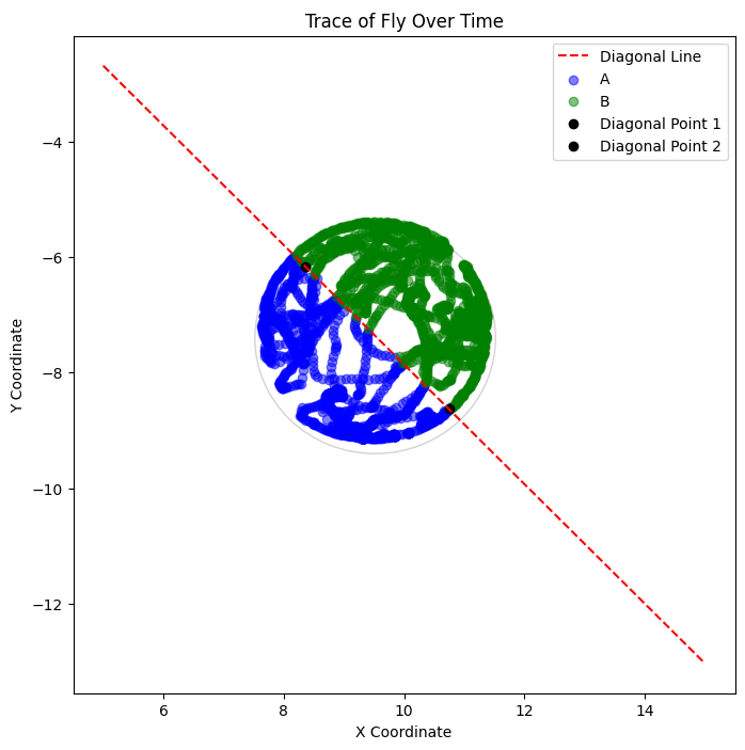

Errors that could occur/Known Bugs:
1. If your fly does not transition at all, or very little their may be an error that gets thrown
2. The Heatmap function always reverses the heatmap for side b, sometimes the heatmap presents the time periods out of order. This is a result of the sorting function, but an unintended consequence. Working On it!
3. Violin plots Y-axis are off sometimes. Unsure why this is happening, but working on it.






Everything is more or less annotated, but if you have any questions, feel free to contact me @TariqMBrown@gmail.com.

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#need to figure out why it won't graph the indivual graphs in the miscellaneous columns for graphics

#heatmaps
#PI with SEM over time
#stats
#clustering of flies
#1 min 20 seconds per 10 flies


In [2]:
# @title Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from matplotlib.colors import Normalize
from matplotlib import cm

In [ ]:
# @title Color Selection
"""
This is where you can select your preferred colors. Either use matploblib friendly color words, which are listed
here: https://matplotlib.org/stable/gallery/color/named_colors.html

or use hexidecimal codes.

You can find palette creators here: https://coolors.co/d7fff1-aafcb8-8cd790-77af9c-285943
and here: http://colormind.io/
"""

colors = ['#00539C', '#EEA47F', '#D9D9D9', 'red', 'gray', 'cyan', '#4b4c7e', '#e0dcb6', '#dfdaca']
colors2 = ['#4b4c7e', '#e0dcb6', '#dfdaca']
palette2 = ["#808080","#8ed4cc","#205072","#b19cd9","#4682b4","#4b0082","#CCCCFF","#708090","#DB7093","#191970"]
custom_palette = ["#b3b3b3","#0000a7","#c1272d","#eecc16","#008176","#4b0082","#CCCCFF","#708090","#DB7093","#191970"]
custom_palette2 = ['#4b4c7e', '#e0dcb6', '#dfdaca']

sns.palplot(sns.cubehelix_palette(8))
sns.palplot(colors)
sns.palplot(colors2)
sns.palplot(palette2)
sns.palplot(custom_palette)


custom_palette = ["#b3b3b3","#0000a7","#c1272d","#eecc16","#008176","#4b0082","#CCCCFF","#708090","#DB7093","#191970"]

In [4]:
# @title Parameters

#Parameters
#These are the metrics that you recorded the video under
FPS = 30 #frames per second used for recording the video
start = 0 # where you want to start analysis from in seconds
stim_onset_1 = 15
stim_offset_1 = 135
stim_onset_2 = 0
stim_offset_2 = 0
end_time = 150
start_time = FPS*start # where in the CSV the analysis will start (in frames)
t1 = stim_onset_1 * FPS
t2 = stim_offset_1 * FPS
t3 = stim_onset_2 * FPS
t4 = stim_offset_2 * FPS
end_time = FPS *end_time
assays = ['Two-Choice (Tandem, Top)', 'Two-Choice (Tandem, Bottom)', 'Two-Choice (Single Circle)', 'Three-Choice (Reuleaux)', ' Three Choice (Mickey Mouse)']
paradigm = assays[0]
tolerance = 900 #every df length below this length will be excluded
path_to_output = '/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Output'

#these substrings are only if you are using flygram video output format, otherwise string isolater and the substrings are irrelevant

substring_1 = '2' #string that starts date time, if this ever becomes the year 3000, change this 3
substring_2 = '_' #string that ends date time
substring_3 = ' ' #string that separates date and time


In [6]:
# @title Dimensions of the Arenas
def arena_designator(string):
  """
  returns inverted coordinates along the y axis that coorespond to the points that you input.
  """

  if string == 'Top':
    diagonal_point1 = (8.18784, 3.98852)
    diagonal_point2 = (10.30177, 2.323388)
    origin_location = (9.61,3.05)
    port_a_location = (8.359,1.275)
    port_b_location = (10.93,4.624)
    #invert to make the code work
    diagonal_point1 = (diagonal_point1[0], -diagonal_point1[1])
    diagonal_point2 = (diagonal_point2[0], -diagonal_point2[1])
    slope, intercept = np.polyfit(diagonal_point1, diagonal_point2, 1)
    origin_location = (origin_location[0], -origin_location[1])
    port_a_location = (port_a_location[0],-port_a_location[1])
    port_b_location = [port_b_location[0],-port_b_location[1]]
  else:
    diagonal_point1 = (8.367, 6.168)
    diagonal_point2 = (10.745, 8.630)
    origin_location = [9.5216,7.403]
    port_a_location = [7.995,8.815]
    port_b_location = [11.09,6.059]
    #invert to make the code work
    diagonal_point1 = (diagonal_point1[0], -diagonal_point1[1])
    diagonal_point2 = (diagonal_point2[0], -diagonal_point2[1])
    slope, intercept = np.polyfit(diagonal_point1, diagonal_point2, 1)
    origin_location = (origin_location[0], -origin_location[1])
    port_a_location = (port_a_location[0],-port_a_location[1])
    port_b_location = [port_b_location[0],-port_b_location[1]]
  return diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location


# Functions

In [7]:
# @title cleaning the input csv and desginating sides as A or B
def gapfill(df):
  """
  this function approximates all the infinites (inf) within the structure, make sure the flies don't start inf
  #if inf start for fly in X,Y, need to set prev to something else
  df (pandas DataFrame): dataframe representing the csv from TRex, this should be the file loaded in
  """
  prev = None
  inf_counter = 0
  #print(type(df))
  for ind, row in df.items(): #could be iterrows
      if row != np.inf:
          if inf_counter:
              if prev is None:
                prev = row
              if row is None:
                row = prev
              prediction = np.linspace(prev, row, num=inf_counter+2)[1:-1]
              df.update(pd.Series(prediction, index=list(range(ind-inf_counter, ind))))
          prev, inf_counter = row, 0
      else:
          inf_counter +=1
def label_point(row):
    point = np.array([row['X#wcentroid (cm)'], -row['Y#wcentroid (cm)']])
    # Compute the determinant to check the orientation
    if paradigm == assays[0]:
      det = np.linalg.det(np.array([diagonal_point1 - point, diagonal_point2 - point]))
      if det > 0:
          return 'A'  # Point is above the line
      else:
          return 'B'  # Point is below the line
    elif paradigm == assays[1]:

      det = np.linalg.det(np.array([diagonal_point1 - point, diagonal_point2 - point]))
      if det > 0:
          return 'B'  # Point is above the line
      else:
          return 'A'  # Point is below the line

# Iterate over the DataFrame and assign labels
def region(df):
  for columns in df.columns:
    gapfill(df[columns])
  for index, row in df.iterrows():
      df.at[index, 'Region'] = label_point(row)
  time_in_a = len(df.loc[df['Region'] == 'A'])
  time_in_b = len(df.loc[df['Region'] == 'B'])
  time_spent = [time_in_a/FPS, time_in_b/FPS]
  #label_counts = df['Region'].value_counts()/FPS
  #label_counts.plot(kind='bar', color=custom_palette2, width = 0.8, edgecolor = 'k')
  #plt.xlabel('Area')
  #plt.ylabel('Time (secs)')
  #plt.title('Time Spent in Each Region')
  #plt.show()

  return df, time_in_a, time_in_b
def string_isolater(string, substring_1, substring_2, substring_3):
  """
  returns two strings that will be used to look for certain files
  string (str): string that you want transformed
  substring_1 (str): the first substring you want to cut from
  substring_1 (str): the second substring you want to cut from
  substring_1 (str): the third substring you want to cut from
  """
  new_string_1 = string[string.find(substring_1): string.find(substring_2)]
  new_string_2 = string[string.find(substring_1): string.find(substring_3)]
  return new_string_1, new_string_2
def func(variable):

  # for checking existence in globals() function
    if variable in globals():
        return True
    else:
        return False

In [8]:
# @title trace
def trace(df, filepath, subject_id):
    x = df['X#wcentroid (cm)']
    y = df['Y#wcentroid (cm)']
    #invert
    y = -y
   # Plotting
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the circle representing the arena
    arena_radius = 2  # Adjust this based on your arena dimensions
    circle = plt.Circle((origin_location), arena_radius, color='lightgray', fill=False)
    ax.add_artist(circle)

    # Plot the diagonal line
    diagonal_line_x = np.linspace(5, 15, 100)
    diagonal_line_y = (diagonal_point2[1] - diagonal_point1[1]) / (diagonal_point2[0] - diagonal_point1[0]) * (diagonal_line_x - diagonal_point1[0]) + diagonal_point1[1]
    ax.plot(diagonal_line_x, diagonal_line_y, color='red', linestyle='--', label='Diagonal Line')

    # Scatter plot for points above and below the diagonal line
    a = df['Region'] == 'A'
    b = df['Region'] == 'B'
    ax.scatter(x[a], y[a], label='A', color='blue', alpha = 0.5)
    ax.scatter(x[b], y[b], label='B', color='green', alpha = 0.5)
    ax.scatter(diagonal_point1[0], diagonal_point1[1], marker='o', color='black', label='Diagonal Point 1')
    ax.scatter(diagonal_point2[0], diagonal_point2[1], marker='o', color='black', label='Diagonal Point 2')

    # Set axis limits
    # ax.set_xlim(7, 12)
    # ax.set_ylim(0, 6)

    # Add labels and legend
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Trace of Fly Over Time')
    ax.legend()
    plt.savefig(os.path.join(filepath, subject_id + ' trace.pdf'), transparent = True)
    #ax.invert_yaxis()

    # Show the plot
    #plt.show()


In [9]:
# @title heat trace
# Function to calculate time above and below the diagonal line and plot the data as a heatmap
def heat_trace(df, filepath, subject_id):

    # Assuming your CSV columns are named 'x', 'y', and 'time'
    x = df['X#wcentroid (cm)']
    y = df['Y#wcentroid (cm)']
    y = -y
    time = df['frame']
    # diagonal_point1 = (8.18784, 3.98852)
    # diagonal_point2 = (10.30177, 2.323388)
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the circle representing the arena
    arena_radius = 2  # Adjust this based on your arena dimensions
    circle = plt.Circle((origin_location), arena_radius, color='lightgray', fill=False)
    ax.add_artist(circle)

    # Plot the diagonal line
    diagonal_line_x = np.linspace(5, 15, 100)
    diagonal_line_y = (diagonal_point2[1] - diagonal_point1[1]) / (diagonal_point2[0] - diagonal_point1[0]) * (diagonal_line_x - diagonal_point1[0]) + diagonal_point1[1]
    ax.plot(diagonal_line_x, diagonal_line_y, color='red', linestyle='--', label='Diagonal Line')


    # Scatter plot for points above and below the diagonal line with heatmap-like color
    above_diagonal = df['Region'] == 'A'
    below_diagonal = df['Region'] == 'B'

    norm = Normalize(vmin=time.min(), vmax=time.max())
    cmap = cm.get_cmap('magma')  # You can change the colormap as needed

    above_scatter = ax.scatter(x[above_diagonal], y[above_diagonal], c=time[above_diagonal], cmap=cmap, norm=norm)
    below_scatter = ax.scatter(x[below_diagonal], y[below_diagonal], c=time[below_diagonal], cmap=cmap, norm=norm)

    # Set axis limits
    # ax.set_xlim(-arena_radius, arena_radius)
    # ax.set_ylim(-arena_radius, arena_radius)

    # Add colorbar
    cbar = fig.colorbar(above_scatter, ax=ax, label='Time')
    cbar.set_label('Frame')

    # Add labels and legend
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Object Positions and Diagonal Line with Heatmap')
    ax.legend()
    plt.savefig(os.path.join(filepath, subject_id + ' heat trace.pdf'), transparent = True)
    #ax.invert_yaxis()

    # Show the plot
    #plt.show()

In [10]:
# @title transitions
def transitions(df):
  transitions_from_A_to_B = 0
  transitions_from_B_to_A = 0
  time_a_to_b = []
  time_b_to_a = []

  for i in range(1, len(df)):
      current_label = df.at[i, 'Region']
      previous_label = df.at[i - 1, 'Region']

      if current_label == 'B' and previous_label == 'A':
          transitions_from_A_to_B += 1
          time_a_to_b.append(df.at[i, 'frame']/FPS)
      elif current_label == 'A' and previous_label == 'B':
          transitions_from_B_to_A += 1
          time_b_to_a.append(df.at[i, 'frame']/FPS)
  total_transitions = transitions_from_A_to_B + transitions_from_B_to_A
  # print(f"Transitions from A to B: {transitions_from_A_to_B}")
  # print(f"Transitions from B to A: {transitions_from_B_to_A}")
  # print(f"Total Number of Transitions: {total_transitions}")
  # print(f"Times at which A to B occured: {time_a_to_b}")
  # print(f"Times at which A to B occured: {time_b_to_a}")
  transition_numbers = pd.DataFrame({'A to B':transitions_from_A_to_B, 'B to A':transitions_from_B_to_A, 'Total Transitions':total_transitions}, index = [1])
  transition_times_b = pd.DataFrame({'A to B times':time_a_to_b})
  transition_times_a = pd.DataFrame({'B to A times':time_b_to_a})
  return transition_numbers, transition_times_b, transition_times_a

In [11]:
# @title preference index
def preference(df):
  count_a = len(df.loc[df['Region'] == 'A'])
  count_b = len(df.loc[df['Region'] == 'B'])
  #count_c = len(df.loc[df['Region'] == 'C'])
  preference_index_a = (count_a - count_b) / (count_a + count_b)
  preference_index_b = (count_b - count_a) / (count_b + count_a)
  preference_indices = {'Preference Index A':preference_index_a, 'Preference Index B':preference_index_b}
  preference_indices = pd.DataFrame.from_dict(preference_indices, orient = 'index')
  return preference_indices

In [12]:
# @title preference index over time
def preference_index_over_time(df):
  rolling_count_A = 0
  rolling_count_B = 0
  rolling_preference_index_A = []
  rolling_preference_index_B = []

  # Iterate over the DataFrame to calculate and append rolling preference indices
  for index, row in df.iterrows():
      if row['Region'] == 'A':
          rolling_count_A += 1
      else:
          rolling_count_B += 1

      preference_index_A = rolling_count_A / (index + 1)
      preference_index_B = rolling_count_B / (index + 1)

      rolling_preference_index_A.append(preference_index_A)
      rolling_preference_index_B.append(preference_index_B)

  # Append rolling preference indices to the DataFrame
  df['rolling_preference_index_A'] = rolling_preference_index_A
  df['rolling_preference_index_B'] = rolling_preference_index_B
  # plt.plot(df.index, df['rolling_preference_index_A'], label='Preference Index A', color = custom_palette2[0])
  # plt.plot(df.index, df['rolling_preference_index_B'], label='Preference Index B', color = custom_palette2[1])
  # plt.xlabel('Time (frame)')
  # plt.ylabel('Preference Index')
  # plt.legend()
  # plt.title('Preference Index Over Time')
  # plt.show()
  # plt.clf()
  return df

In [13]:
# @title distance, velocity, acceleration
# Function to calculate Euclidean distance between two points
def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Port coordinates

# Initialize variables for distance calculations


def distancing(df):
  # Iterate over the DataFrame to calculate distances
  previous_position = (df['X#wcentroid (cm)'].iloc[0], df['Y#wcentroid (cm)'].iloc[0])
  df_moved_area_A = pd.DataFrame({})
  df_moved_area_B = pd.DataFrame({})
  total_distance_moved = []
  distance_moved_A = []
  distance_moved_B = []
  distance_from_center = []
  distance_from_port_A = []
  distance_from_port_B = []

  for index, row in df.iterrows():
      current_position = (row['X#wcentroid (cm)'], row['Y#wcentroid (cm)'])

      total_distance_moved.append(distance(previous_position, current_position))

      # Calculate distance moved in 'A' and 'B'
      if row['Region'] == 'A':
          distance_moved_A.append(distance(previous_position, current_position))
      elif row['Region'] == 'B':
          distance_moved_B.append(distance(previous_position, current_position))

      # Calculate distance from the center
      distance_from_center.append(distance(current_position, origin_location))

      # Calculate distance from port A
      distance_from_port_A.append(distance(current_position, port_a_location))

      # Calculate distance from port B
      distance_from_port_B.append(distance(current_position, port_b_location))

      previous_position = current_position

  # Add calculated distances to the DataFrame
  df['Distance Moved'] = total_distance_moved
  df_moved_area_A['Distance Moved (A)'] = distance_moved_A
  df_moved_area_B['Distance Moved (B)'] = distance_moved_B
  df['Origin Distance'] = distance_from_center
  df['Port Distance (A)'] = distance_from_port_A
  df['Port Distance (B)'] = distance_from_port_B

  df_a = df[df['Region'] == 'A']
  df_b = df[df['Region'] == 'B']

  average_velocity_a = df_a.groupby('Region')['SPEED (cm/s)'].mean()
  average_velocity_b = df_b.groupby('Region')['SPEED (cm/s)'].mean()
  average_acceleration_a = df_a.groupby('Region')['ACCELERATION#wcentroid (cm/s2)'].mean()
  average_acceleration_b = df_b.groupby('Region')['ACCELERATION#wcentroid (cm/s2)'].mean()
  # print(average_velocity_a[0])
  # print(average_velocity_b[0])
  # print(average_acceleration_a[0])
  # print(average_acceleration_b[0])

  return df, df_moved_area_A, df_moved_area_B, average_velocity_a, average_velocity_b,average_acceleration_a,average_acceleration_b




In [14]:
# @title bouts
def bouty(df):
  """
  returns a csv that has bout duration information
  and a sorted df that will be used in future functions
  df (pandas dataframe): annotated csv
  filename (str): string representing desired filename
  """
  bouts = pd.DataFrame(columns = ['Bout', 'Region', 'Start', 'End',
                                  'Distance Moved', 'Acceleration', 'Port Distance (A)',
                                  'Port Distance (B)', 'Origin Distance', 'Velocity'])
  bout, region, start, end, distance_moved, acceleration, port_a_distance, port_b_distance, origin_distance, velocity = 0, None, None, None, 0, 0, 0, 0, 0, 0
  tot_dist = 0
  row_count = 1
  last_row = len(df)-1
  last_region = None
  for index, row in df.iterrows():
    if index == 0:
      region = row['Region']
      start = row['time']
      last_coords = row[['X#wcentroid (cm)', 'Y#wcentroid (cm)']]
      last_region = row['Region']
      velocity = row['SPEED (cm/s)']
      acceleration = row['ACCELERATION#wcentroid (cm/s2)']
      port_a_distance = row['Port Distance (A)'] # have to change this Port Distance ('A, B, C')
      port_b_distance = row['Port Distance (B)']
      origin_distance = row['Origin Distance']
      continue
    elif index == last_row:
      region = row['Region']
      acc = acceleration/row_count
      vel = velocity/row_count
      port_a_dist = port_a_distance/row_count
      port_b_dist = port_b_distance/row_count
      orgin_dist = origin_distance/row_count
      bouts = pd.concat([bouts, pd.DataFrame({'Bout':bout,
                                              'Region': region,
                                              'Start':start,
                                              'End': end,
                                              'Distance Moved': tot_dist,
                                              'Acceleration': acc,
                                              'Port Distance (A)':port_a_dist,
                                              'Port Distance (B)':port_b_dist,
                                              'Origin Distance':orgin_dist,
                                              'Velocity':vel,
                                              'Bout Duration':row['time']-start}, index = [0])], ignore_index = True)

    elif row['Region'] != last_region:
      region = last_region #changed this from row['Region']
      acc = acceleration/row_count
      vel = velocity/row_count
      port_a_dist = port_a_distance/row_count
      port_b_dist = port_b_distance/row_count
      origin_dist = origin_distance/row_count
      end = row['time']
      bouts = pd.concat([bouts, pd.DataFrame({'Bout':bout,
                                              'Region': region,
                                              'Start':start,
                                              'End': end,
                                              'Distance Moved': tot_dist,
                                              'Acceleration': acc,
                                              'Port Distance (A)':port_a_dist,
                                              'Port Distance (B)':port_b_dist,
                                              'Origin Distance':origin_dist,
                                              'Velocity':vel,
                                              'Bout Duration':row['time']-start}, index = [0])], ignore_index = True)

      last_region = row['Region']
      start = end
      tot_dist = 0 # need to change these to 0 so you don't double add
      acceleration = 0
      velocity = 0
      port_a_distance = 0
      port_b_distance = 0
      port_c_distance = 0
      origin_distance = 0
      row_count = 0
      bout += 1
    cur_coords = row[['X#wcentroid (cm)', 'Y#wcentroid (cm)']]
    tot_dist += np.linalg.norm(cur_coords - last_coords)
    last_coords = cur_coords
    acceleration += row['ACCELERATION#wcentroid (cm/s2)']
    velocity += row['SPEED (cm/s)']
    port_a_distance += row['Port Distance (A)']
    port_b_distance += row['Port Distance (B)']
    origin_distance += row['Origin Distance']
    row_count += 1
  sorted = bouts.groupby('Region')
  al = sorted.mean()
  avgboutdur = al['Bout Duration']
  return bouts, sorted, avgboutdur

In [15]:
# @title compile 1
def compile(annotated_df, time_in_a, time_in_b, preference_indices, df_moved_area_A, df_moved_area_B, avgboutdur, transition_numbers, vel_a, vel_b, acc_a, acc_b):
  #take the averages from each of the dataframes
  mean_df = pd.DataFrame({})
  mean_df['Time in Area (A)'] = [time_in_a/FPS] #there was an issue here where it was NaNning all numbers if i didnt add brackets to just this row, IDEK WTF
  mean_df['Time in Area (B)'] = time_in_b/FPS
  mean_df['Preference Index (A)'] = preference_indices[0][0]
  mean_df['Preference Index (B)'] = preference_indices[0][1]
  mean_df['Average Port Distance (A)'] = annotated_df['Port Distance (A)'].mean()
  mean_df['Average Port Distance (B)'] = annotated_df['Port Distance (B)'].mean()
  mean_df['Origin Distance'] =  annotated_df['Origin Distance'].mean()
  mean_df['Average Velocity'] =  annotated_df['SPEED (cm/s)'].mean()
  mean_df['Average Acceleration'] = annotated_df['ACCELERATION#wcentroid (cm/s2)'].mean()
  mean_df['Total Distance Moved'] = annotated_df['Distance Moved'].sum()
  mean_df['Total Distance Moved (A)'] = df_moved_area_A.to_numpy().sum()
  mean_df['Total Distance Moved (B)'] = df_moved_area_B.to_numpy().sum()
  mean_df['Total Transitions'] = transition_numbers['Total Transitions'].iloc[0]
  if mean_df['Total Transitions'][0] > 0:
    if func(transition_numbers['A to B'].iloc[0]) == True: mean_df['A to B'] = transition_numbers['A to B'].iloc[0]
    if func(transition_numbers['B to A'].iloc[0]) == True: mean_df['B to A'] = transition_numbers['B to A'].iloc[0]
    if func(vel_a[0]) == True: mean_df['Average Velocity (A)'] = vel_a[0] #can change these to be
    if func(vel_b[0]) == True: mean_df['Average Velocity (B)'] = vel_b[0]
    if func(acc_a[0]) == True: mean_df['Average Acceleration (A)'] = acc_a[0]
    if func(acc_b[0]) == True: mean_df['Average Acceleration (B)'] = acc_b[0]
    if func(avgboutdur[0]) == True: mean_df['Average Bout (A)'] = avgboutdur[0]
    if func(avgboutdur[1]) == True: mean_df['Average Bout (B)'] = avgboutdur[1]
    print(mean_df)
  return mean_df
# individual_metrics = compile(annotated_df, time_in_a, time_in_b, preference_indices, df_moved_area_A, df_moved_area_B, avgboutdur, transition_numbers, vel_a, vel_b, acc_a, acc_b)
# print(individual_metrics)

In [16]:
# @title new compile, but without the fix for little-to-no transitions
def compile(annotated_df, time_in_a, time_in_b, preference_indices, df_moved_area_A, df_moved_area_B, avgboutdur, transition_numbers, vel_a, vel_b, acc_a, acc_b):
  #take the averages from each of the dataframes
  mean_df = pd.DataFrame({})
  mean_df['Time in Area (A)'] = [time_in_a/FPS] #there was an issue here where it was NaNning all numbers if i didnt add brackets to just this row, IDEK WTF
  mean_df['Time in Area (B)'] = time_in_b/FPS
  mean_df['Preference Index (A)'] = preference_indices[0][0]
  mean_df['Preference Index (B)'] = preference_indices[0][1]
  mean_df['Average Port Distance (A)'] = annotated_df['Port Distance (A)'].mean()
  mean_df['Average Port Distance (B)'] = annotated_df['Port Distance (B)'].mean()
  mean_df['Origin Distance'] =  annotated_df['Origin Distance'].mean()
  mean_df['Average Velocity'] =  annotated_df['SPEED (cm/s)'].mean()
  mean_df['Average Acceleration'] = annotated_df['ACCELERATION#wcentroid (cm/s2)'].mean()
  mean_df['Total Distance Moved'] = annotated_df['Distance Moved'].sum()
  mean_df['Total Distance Moved (A)'] = df_moved_area_A.to_numpy().sum()
  mean_df['Total Distance Moved (B)'] = df_moved_area_B.to_numpy().sum()
  mean_df['Total Transitions'] = transition_numbers['Total Transitions'].iloc[0]
  if mean_df['Total Transitions'][0] > 0:
    mean_df['A to B'] = transition_numbers['A to B'].iloc[0]
    mean_df['B to A'] = transition_numbers['B to A'].iloc[0]
    mean_df['Average Velocity (A)'] = vel_a[0]
    mean_df['Average Velocity (B)'] = vel_b[0]
    mean_df['Average Acceleration (A)'] = acc_a[0]
    mean_df['Average Acceleration (B)']=acc_b[0]
    mean_df['Average Bout (A)'] = avgboutdur[0]
    mean_df['Average Bout (B)'] = avgboutdur[1]
  return mean_df

In [26]:
# @title violin and barplots for batches
def individual_violins(df, column_list, filepath):
  """
  If you want to graph individual violins for your metrics use this
  df(pandas dataframe): this is typically the merged_df with all the subjects average metrics
  column_list (np array): this is a list of the columns you want plotted)
  filepath (str): where to save the graphs
  """
  for column in column_list:
    plt.figure(figsize=(8, 6))
    sns.violinplot(y=column, data=df, palette = custom_palette2, inner='box')
    plt.ylabel(column)
    plt.title(f'Violin Plot for {column}')
    plt.savefig(os.path.join(filepath, 'Violin Plot for ' + column + '.pdf'), transparent = True)
    plt.clf()
    sns.boxplot(y=column, data=df, palette = custom_palette2)
    sns.swarmplot(y=column, data=df, palette = custom_palette2, size=5, edgecolor='k', linewidth = 1, alpha = 0.5)
    plt.ylabel(column)
    plt.title(f'Box Plot for {column}')
    plt.savefig(os.path.join(filepath, 'Box Plot for ' + column + '.pdf'), transparent = True)
    plt.clf()

def combined_violins(df, column_list, filepath):
  """
  If you want to graph violinplots side-by-side use this definition
  df(pandas dataframe): this is typically the merged_df with all the subjects average metrics
  column_list (np array): this is a list of the columns you want plotted on the same chart (if the have (X) at the end, I subtracted the last 4 for title)
  filepath (str): where to save the graphs
  """
  plt.figure(figsize=(8, 6))
  sns.violinplot(x='variable', y='value', data=pd.melt(df[column_list]), palette = custom_palette2, inner = 'box')
  #plt.xlabel('Columns')
  #plt.ylabel('Values')
  plt.title('Violin Plot for ' + column_list[0][:-4])
  plt.savefig(os.path.join(filepath, 'Violin Plot for ' + column_list[0][:-4] + '.pdf'), transparent = True)
  plt.clf()
  sns.boxplot(x='variable', y='value', data=pd.melt(df[column_list]), palette = custom_palette2)
  sns.swarmplot(x='variable', y='value', data=pd.melt(df[column_list]), palette = custom_palette2, size=5, edgecolor='k', linewidth = 1, alpha = 0.5)
  plt.savefig(os.path.join(filepath, 'Box Plot for ' + column_list[0][:-4] + '.pdf'), transparent = True)
  plt.show()

def combined_violins(df, column_list, filepath):
  """
  If you want to graph violinplots side-by-side use this definition with lineplots ONLY WORKS ONE AT A TIME DOES NOT WORK WITH LOOP
  df(pandas dataframe): this is typically the merged_df with all the subjects average metrics
  column_list (np array): this is a list of the columns you want plotted on the same chart (if the have (X) at the end, I subtracted the last 4 for title)
  filepath (str): where to save the graphs
  """
  #sns.set_style(style = None)
  #sns.despine(left=True, bottom = True)
  #plt.tick_params(left = False, bottom = False)
  plt.figure(figsize=(8, 6))
  sns.violinplot(x='variable', y='value', data=pd.melt(df[column_list]), palette = custom_palette2, inner = 'box')
  for index, row in df.iterrows():
    sns.lineplot(x=[column_list[0], column_list[1]], y=row[[column_list[0], column_list[1]]], color = 'k')
  #plt.ylim(-1,1) #change these to fit your violin plot
  plt.xlim(-.5,1.5) #change these to fit your violin plot
  plt.xlabel('Place Holder')
  plt.ylabel('Values')
  plt.title('Violin Plot for ' + column_list[0][:-4])
  plt.savefig(os.path.join(filepath, 'Violin Plot for ' + column_list[0][:-4] + '.pdf'), transparent = True)
  plt.show()


Individual Fly Processing

In [27]:
# @title heatmap for batches
def heatmappy(df,filepath, side, bin_size = 16):
  """
  how to derive bin size, the lengths of these videos are about 4500, if you want 10 second bins the bin size has to be 4500/10 * FPS
  """
  binner = np.linspace(start, end_time, bin_size) # last number here is bin size where you wanna change
  df['buckets'] = pd.cut(df['frame'], binner) #qcut>cut, because qcut is inclusive, or use -1
  tempdf = df.groupby(by='buckets').mean().drop(columns=['frame'])
  a = list(tempdf.columns.values)
  #print(tempdf.mean(axis = 1))
  # Sort the DataFrame by mean preference index in descending order
  df_binned_sorted = tempdf.mean(axis=1).sort_values(ascending=False).index
  df_binned_sorted = tempdf.loc[df_binned_sorted]

  # Create a heatmap with row labels as column names

  plt.figure(figsize=(10, 6))
  sns.heatmap(df_binned_sorted.T, cmap='magma', cbar_kws={'label': 'Preference Index'}, center=0, vmin=-1, vmax=1)
  plt.xlabel('Time')
  plt.ylabel('Fly')
  #plt.axvline(x=310, color = 'k') #puts a vertical line where the stimulation is ~ 10 seconds in
  plt.title('Heatmap of Preference Index Scores ' + side + '- Sorted')
  plt.savefig(os.path.join(filepath, side + ' Heatmap.pdf'), transparent = True)
  plt.show()

In [ ]:
# @title Using Counts of A vs B for Preference Index over time
def ration (df):
  """
  This is the method that counts side A vs Side B overall to determine Preference Index
  """
  #sum the numbers of As and Bs for each row and generate a column of each
  counts_A = df.iloc[:, 1:].apply(lambda row: row.eq('A').sum(), axis=1)
  counts_B = df.iloc[:, 1:].apply(lambda row: row.eq('B').sum(), axis=1)
  #create a ration
  ratio_a = (counts_A - counts_B) / (counts_A + counts_B)
  ratio_b = (counts_B - counts_A) / (counts_A + counts_B)
  df['Ratio_A'] = ratio_A
  df['Ratio_B'] = ratio_B

  # Plot Ratio A
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(df['frame'], df['Ratio_A'], color='blue')
  plt.title('Ratio A')
  plt.xlabel('Frame')
  plt.ylabel('Ratio')

  # Plot Ratio B
  plt.subplot(1, 2, 2)
  plt.plot(df['frame'], df['Ratio_B'], color='red')
  plt.title('Ratio B')
  plt.xlabel('Frame')
  plt.ylabel('Ratio')

  plt.tight_layout()
  plt.show()
  return ratio_a, ratio_b

# Individual File Processing

In [8]:
# Individual Fly Top Arena
csv_files = ['/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Raw TRex Output/2023-12-01 Dop2R Alcohol Memory TRex Output/Dop2R-Control/15.38.51/Top/data/video--2023-12-01 15.38.51_fish9.csv']
diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Top')
for csv_file in csv_files:
  df = pd.read_csv(csv_file)
annotated_df, time_in_a, time_in_b = region(df)

In [ ]:
# Individual Fly Bottom
csv_files = ['/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Raw TRex Output/2023-12-01 Dop2R Alcohol Memory TRex Output/Dop2R-Control/16.11.42/Bottom/data/video--2023-12-01 16.11.42_fish0.csv']
diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Bottom')
for csv_file in csv_files:
  df = pd.read_csv(csv_file)
annotated_df, time_in_a, time_in_b = region(df)

In [ ]:
trace(df, filepath, 'Enter Subject ID Here')

In [ ]:
heat_trace(df, filepath, 'Enter Subject ID Here')

In [ ]:
transition_numbers, transition_times_b, transition_times_a = transitions(annotated_df)

In [ ]:
preference_indices = preference(annotated_df)

In [ ]:
annotated_df =preference_index_over_time(annotated_df)

In [ ]:
annotated_df, df_moved_area_A, df_moved_area_B, vel_a,vel_b,acc_a,acc_b = distancing(annotated_df)

In [ ]:
bouts, sorted, avgboutdur = bouty(annotated_df)

In [ ]:
individual_metrics = compile(annotated_df, time_in_a, time_in_b, preference_indices, df_moved_area_A, df_moved_area_B, avgboutdur, transition_numbers, vel_a, vel_b, acc_a, acc_b)
print(individual_metrics)

In [ ]:
# @title individual all metrics graphing
#plot all columns as individual bar graphs
metrics_columns = [col for col in individual_metrics.columns]

# Iterate through time columns and create individual plots
plt.figure(figsize=(8, 6))
for column in metrics_columns:
    plt.bar(individual_metrics['ID'], individual_metrics[column], label = column, color=custom_palette2,
            width = 0.8, edgecolor = 'k')
    plt.title(f'Plot for {column}')
    plt.xlabel('ID')
    plt.ylabel(column)
    #plt.grid(True)
    plt.show()

In [ ]:
# @title individual time graphing
time_columns = [col for col in individual_metrics.columns if 'Time in' in col]
plt.figure(figsize=(8, 6))
plt.bar(time_columns, [individual_metrics['Time in Area (A)'][0],individual_metrics['Time in Area (B)'][0]], color = custom_palette2,
        width = 0.8, edgecolor = 'k')
plt.title(f'Time Spent')
plt.xlabel('Area')
plt.ylabel('Time (secs)')
#plt.grid(True)
plt.show()

In [ ]:
# @title individual port graphing
port_columns = [col for col in individual_metrics.columns if 'Port Distance' in col]
plt.figure(figsize=(8, 6))
plt.bar(port_columns, [(individual_metrics['Average Port Distance (A)'][0]/2),(individual_metrics['Average Port Distance (B)'][0]/2)], color = custom_palette2,
        width = 0.8, edgecolor = 'k')
plt.title(f'Port Distance')
plt.xlabel('Area')
plt.ylabel('Port Distance (cm)')
plt.show()

In [ ]:
# @title individual distance graphing
distance_columns = [col for col in individual_metrics.columns if 'Distance Moved (' in col]
plt.figure(figsize=(8, 6))
plt.bar(distance_columns, [individual_metrics['Total Distance Moved (A)'][0],individual_metrics['Total Distance Moved (B)'][0]], color = custom_palette2,
        width = 0.8, edgecolor = 'k')
plt.title(f'Distance Moved')
plt.xlabel('Area')
plt.ylabel('Distance (cm)')
plt.show()

In [ ]:
# @title individual velocity graphing
velocity_columns = [col for col in individual_metrics.columns if 'Velocity (' in col]
plt.figure(figsize=(8, 6))
plt.bar(velocity_columns, [individual_metrics['Average Velocity (A)'].iloc[0],individual_metrics['Average Velocity (B)'].iloc[0]], color = custom_palette2,
        width = 0.8, edgecolor = 'k')
plt.title(f'Velocity')
plt.xlabel('Area')
plt.ylabel('Velocity (cm/s)')
plt.show()

In [ ]:
# @title individual bout graphing
bout_columns = [col for col in individual_metrics.columns if 'Bout' in col]
plt.figure(figsize=(8, 6))
plt.bar(bout_columns, [individual_metrics['Average Bout (A)'][0],individual_metrics['Average Bout (B)'][0]], color = custom_palette2,
        width = 0.8, edgecolor = 'k')
plt.title(f'Average Bout Duration')
plt.xlabel('Area')
plt.ylabel('Bout Duration (secs)')
plt.show()

In [ ]:
# @title individual preference index graphing
preference_columns = [col for col in individual_metrics.columns if 'Preference Index' in col]
plt.figure(figsize=(8, 6))
plt.bar(preference_columns, [individual_metrics['Preference Index (A)'][0],individual_metrics['Preference Index (B)'][0]], color = custom_palette2,
        width = 0.8, edgecolor = 'k')
plt.title(f'Preference Index')
plt.xlabel('Area')
plt.axhline(y=0, color='k', linestyle='--')
plt.ylabel('Preference Index')
plt.ylim(-1,1)
plt.text(preference_columns[0], individual_metrics['Preference Index (A)'][0] + 0.1, str(individual_metrics['Preference Index (A)'][0]))
plt.text(preference_columns[1], individual_metrics['Preference Index (B)'][0] + 0.1, str(individual_metrics['Preference Index (B)'][0]))
plt.show()

In [ ]:
# @title individual preference graphing
#plot preference indices
preference_columns = [col for col in individual_metrics.columns if 'Preference' in col]

# Iterate through time columns and create individual plots
plt.figure(figsize=(8, 6))
for column in preference_columns:
    plt.bar(individual_metrics['ID'], individual_metrics[column], label = column, color=custom_palette2,
            width = 0.8, edgecolor = 'k')
    plt.title(f'Plot for {column}')
    plt.xlabel('ID')
    plt.ylabel('Preference Index')
    plt.ylim(-1,1)
    plt.axhline(y=0, color='k', linestyle='--')
    plt.show()

In [ ]:
# @title individual misc columns graphing
columns = ['Average Velocity','Average Acceleration','Origin Distance','Total Distance Moved','Total Transitions']

# Iterate through time columns and create individual plots
plt.figure(figsize=(8, 6))
for column in columns:
    plt.bar(individual_metrics['ID'], individual_metrics[column], label = column, color=custom_palette2,
            width = 0.8, edgecolor = 'k')
    plt.title(f'Plot for {column}')
    plt.xlabel('ID')
    plt.ylabel(column)
    plt.axhline(y=0, color='k', linestyle='--')
    plt.show()

# Batch Processing Top and Bottom

In [ ]:
"""
Loop through a directory and perform 'insert new name here' on all the files in the directory and create a merged csv with all subjects
Directory = drive/super_folder
super_folder = folder containing date_time_folder

date_time_folder contains positions folders "Top" or "Bottom"
"Top" or "Bottom" folders contain the data folders that have the individual subject csvs

"""
path_to_output = '/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Output'
project = 'Dop2R Splice Mutant Alcohol Memory'
date = '2023-12-01'
path_to_project = os.path.join(path_to_output)
columns_for_individual_violins = ['Average Velocity', 'Average Acceleration', 'Origin Distance','Total Distance Moved',
                                  'Total Transitions', 'A to B', 'B to A', 'Preference Index (A)','Preference Index (B)']
grouped_columns_for_violins = [['Total Distance Moved (A)', 'Total Distance Moved (B)'],
                               ['Average Velocity (A)', 'Average Velocity (B)'],
                               ['Average Acceleration (A)', 'Average Acceleration (B)'],
                               ['Average Port Distance (A)', 'Average Port Distance (B)'],
                               ['Average Bout (A)', 'Average Bout (B)'],
                               ['Time in Area (A)', 'Time in Area (B)']]
#grouped_columns_for_violins = [['Preference Index (A)', 'Preference Index (B)']] #the grouped columns with lines only works for single ones
try:
  os.mkdir(path_to_project)
except OSError as error:
  pass
def top_coolacronym(directory, date):
  for super_folder in os.listdir(directory):
    path_to_super_folder = os.path.join(path_to_project, super_folder)
    try:
      os.mkdir(path_to_super_folder)
    except OSError as error:
      pass
    path_to_date = os.path.join(path_to_super_folder, date)
    try:
      os.mkdir(path_to_date)
    except OSError as error:
      pass
    for time_folder in os.listdir(os.path.join(directory, super_folder)):
      path_to_time = os.path.join(path_to_date, time_folder)
      try:
        os.mkdir(path_to_time)
      except OSError as error:
        pass
      for position_folder in os.listdir(os.path.join(directory,super_folder,time_folder)):
        path_to_position = os.path.join(path_to_time, position_folder)
        try:
          os.mkdir(path_to_position)
        except OSError as error:
          pass
        path_to_traces = os.path.join(path_to_position, 'Traces')
        try:
          os.mkdir(path_to_traces)
        except OSError as error:
          pass
        path_to_graphics = os.path.join(path_to_position, 'Graphics')
        try:
          os.mkdir(path_to_graphics)
        except OSError as error:
          pass
        path_to_individual_csvs = os.path.join(path_to_position, 'Individual CSVs')
        try:
          os.mkdir(path_to_individual_csvs)
        except OSError as error:
          pass
        merged_df = pd.DataFrame()
        merged_PI_A_overtime_df = pd.DataFrame()
        merged_PI_B_overtime_df = pd.DataFrame()
        merged_region_df = pd.DataFrame()
        if position_folder == 'Top':
          for filename in os.listdir(os.path.join(directory,super_folder,time_folder, position_folder, 'data')):
            date_time, date = string_isolater(filename, substring_1, substring_2, substring_3)
            subject_id = filename[-5:-4] #adjust these numbers to get to the number of your subject
            print(filename, '', position_folder)
            f = (os.path.join(directory,super_folder,time_folder, position_folder, 'data', filename))
            df = pd.read_csv(f)
            if len(df) < tolerance: continue
            df = df.iloc[start_time: end_time]
            df = df.reset_index()
            annotated_df, time_in_a, time_in_b = region(df)
            trace(df, path_to_traces, subject_id)
            heat_trace(df, path_to_traces, subject_id)
            transition_numbers, transition_times_b, transition_times_a = transitions(annotated_df)
            preference_indices = preference(annotated_df)
            annotated_df =preference_index_over_time(annotated_df)
            annotated_df, df_moved_area_A, df_moved_area_B, vel_a,vel_b,acc_a,acc_b = distancing(annotated_df)
            bouts, sorted, avgboutdur = bouty(annotated_df)
            annotated_df.to_csv(os.path.join(path_to_individual_csvs, 'Subject ' + subject_id + ' Annotated.csv'),index = False)
            bouts.to_csv(os.path.join(path_to_individual_csvs, 'Subject ' + subject_id + ' Bouts.csv'),index = False)
            individual_metrics = compile(annotated_df, time_in_a, time_in_b, preference_indices, df_moved_area_A, df_moved_area_B, avgboutdur, transition_numbers, vel_a, vel_b, acc_a, acc_b)
            individual_metrics.insert(0, 'Subject ID',  [subject_id])
            merged_df = pd.concat([merged_df, individual_metrics])
            merged_PI_A_overtime_df = pd.concat([merged_PI_A_overtime_df, annotated_df['rolling_preference_index_A']], axis = 1)
            merged_PI_A_overtime_df.rename(columns={'rolling_preference_index_A': subject_id}, inplace=True)
            merged_PI_A_overtime_df['frame'] = range(1, len(merged_PI_A_overtime_df) + 1)
            merged_PI_B_overtime_df = pd.concat([merged_PI_B_overtime_df, annotated_df['rolling_preference_index_B']], axis = 1)
            merged_PI_B_overtime_df.rename(columns={'rolling_preference_index_B': subject_id}, inplace=True)
            merged_PI_B_overtime_df['frame'] = range(1, len(merged_PI_B_overtime_df) + 1)
            merged_region_df = pd.concat([merged_region_df, annotated_df['Region']], axis = 1)
            merged_region_df.rename(columns={'Region': subject_id}, inplace=True)
            merged_region_df['frame'] = range(1, len(merged_region_df) + 1)
          merged_df.to_csv(os.path.join(path_to_position, date_time + ' Merged.csv'),index = False)
          merged_PI_A_overtime_df.to_csv(os.path.join(path_to_position, date_time + ' PI_A_Overtime.csv'),index = False)
          merged_PI_B_overtime_df.to_csv(os.path.join(path_to_position, date_time + ' PI_B_Overtime.csv'),index = False)
          merged_region_df.to_csv(os.path.join(path_to_position, date_time + ' Merged_Region.csv'),index = False)
          print('Finished A Folder-- Going to Plot Metrics')
          individual_violins(merged_df, columns_for_individual_violins, path_to_graphics)
          for pair in grouped_columns_for_violins:
            combined_violins(merged_df, pair, path_to_graphics)
          heatmappy(merged_PI_A_overtime_df, path_to_graphics, 'Side A')
          heatmappy(merged_PI_B_overtime_df, path_to_graphics, 'Side B')
          ration(merged_region_df)



def bottom_coolacronym(directory, date):
  for super_folder in os.listdir(directory):
    path_to_super_folder = os.path.join(path_to_project, super_folder)
    path_to_date = os.path.join(path_to_super_folder, date)
    try:
      os.mkdir(path_to_super_folder)
      os.mkdir(path_to_date)
    except OSError as error:
      pass
    for time_folder in os.listdir(os.path.join(directory, super_folder)):
      path_to_time = os.path.join(path_to_date, time_folder)
      try:
        os.mkdir(path_to_time)
      except OSError as error:
        pass
      for position_folder in os.listdir(os.path.join(directory,super_folder,time_folder)):
        path_to_position = os.path.join(path_to_time, position_folder)
        try:
          os.mkdir(path_to_position)
        except OSError as error:
          pass
        path_to_traces = os.path.join(path_to_position, 'Traces')
        try:
          os.mkdir(path_to_traces)
        except OSError as error:
          pass
        path_to_graphics = os.path.join(path_to_position, 'Graphics')
        try:
          os.mkdir(path_to_graphics)
        except OSError as error:
          pass
        path_to_individual_csvs = os.path.join(path_to_position, 'Individual CSVs')
        try:
          os.mkdir(path_to_individual_csvs)
        except OSError as error:
          pass
        merged_df = pd.DataFrame()
        merged_PI_A_overtime_df = pd.DataFrame()
        merged_PI_B_overtime_df = pd.DataFrame()
        merged_region_df = pd.DataFrame()
        if position_folder == 'Bottom':
          diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Bottom')
          for filename in os.listdir(os.path.join(directory,super_folder,time_folder, position_folder, 'data')):
            date_time, date = string_isolater(filename, substring_1, substring_2, substring_3)
            print(filename, '', position_folder)
            subject_id = [filename[-5:-4]] #adjust these numbers to get to the number of your subject
            f = (os.path.join(directory,super_folder,time_folder, position_folder, 'data', filename))
            df = pd.read_csv(f)
            if len(df) < tolerance: continue
            df = df.iloc[start_time: end_time]
            df = df.reset_index()
            annotated_df, time_in_a, time_in_b = region(df)
            trace(df)
            heat_trace(df)
            transition_numbers, transition_times_b, transition_times_a = transitions(annotated_df)
            preference_indices = preference(annotated_df)
            annotated_df =preference_index_over_time(annotated_df)
            annotated_df, df_moved_area_A, df_moved_area_B, vel_a,vel_b,acc_a,acc_b = distancing(annotated_df)
            bouts, sorted, avgboutdur = bouty(annotated_df)
            annotated_df.to_csv(os.path.join(path_to_individual_csvs, 'Subject ' + subject_id + ' Annotated.csv'),index = False)
            bouts.to_csv(os.path.join(path_to_individual_csvs, 'Subject ' + subject_id + ' Bouts.csv'),index = False)
            individual_metrics = compile(annotated_df, time_in_a, time_in_b, preference_indices, df_moved_area_A, df_moved_area_B, avgboutdur, transition_numbers, vel_a, vel_b, acc_a, acc_b)
            individual_metrics.insert(0, 'Subject ID',  [subject_id])
            individual_metrics.to_csv(os.path.join(path_to_individual_csvs, 'Subject ' + subject_id + ' Annotated.csv'),index = False)

            merged_df = pd.concat([merged_df, individual_metrics])

            merged_PI_A_overtime_df = pd.concat([merged_PI_A_overtime_df, annotated_df['rolling_preference_index_A']], axis = 1)
            merged_PI_A_overtime_df.rename(columns={'rolling_preference_index_A': subject_id}, inplace=True)
            merged_PI_A_overtime_df['frame'] = range(1, len(merged_PI_A_overtime_df) + 1)
            first_column = merged_PI_A_overtime_df.pop('frame')
            merged_PI_A_overtime_df.insert(0, 'frame', first_column)

            merged_PI_B_overtime_df = pd.concat([merged_PI_B_overtime_df, annotated_df['rolling_preference_index_B']], axis = 1)
            merged_PI_B_overtime_df.rename(columns={'rolling_preference_index_B': subject_id}, inplace=True)
            merged_PI_B_overtime_df['frame'] = range(1, len(merged_PI_B_overtime_df) + 1)
            first_column = merged_PI_B_overtime_df.pop('frame')
            merged_PI_B_overtime_df.insert(0, 'frame', first_column)

            merged_region_df = pd.concat([merged_region_df, annotated_df['Region']], axis = 1)
            merged_region_df.rename(columns={'Region': subject_id}, inplace=True)
            merged_region_df['frame'] = range(1, len(merged_region_df) + 1)
            first_column = merged_region_df.pop('frame')
            merged_region_df.insert(0, 'frame', first_column)
          merged_df.to_csv(os.path.join(path_to_position, date_time + ' Merged.csv'),index = False)
          merged_PI_A_overtime_df.to_csv(os.path.join(path_to_position, date_time + ' PI_A_Overtime.csv'),index = False)
          merged_PI_B_overtime_df.to_csv(os.path.join(path_to_position, date_time + ' PI_B_Overtime.csv'),index = False)
          merged_region_df.to_csv(os.path.join(path_to_position, date_time + ' Merged_Region.csv'),index = False)

          print('Finished A Folder-- Going to Plot Metrics')
          individual_violins(merged_df, columns_for_individual_violins, path_to_graphics)
          for pair in grouped_columns_for_violins:
            combined_violins(merged_df, pair, path_to_graphics)
          heatmappy(merged_PI_A_overtime_df, path_to_graphics, 'Side A')
          heatmappy(merged_PI_B_overtime_df, path_to_graphics, 'Side B')
          ration(merged_region_df)




In [ ]:
directory = '/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Raw TRex Output/2023-12-01 Dop2R Alcohol Memory TRex Output'
diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Top')
top_coolacronym(directory, date)

diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Bottom')
bottom_coolacronym(directory, date)

# Work in progress

In [ ]:
"""
"""
"""
everything below here needs to be worked on
"""
"""
"""

In [ ]:
# @title Dimensions of the Arenas
"""
This is where you set the origin point and the diagonal points if the lines you want to use
"""
if paradigm == 'Two-Choice (Tandem, Top)':
  diagonal_point1 = (8.18784, 3.98852)
  diagonal_point2 = (10.30177, 2.323388)
  origin_location = (9.61,3.05)
  port_a_location = (8.359,1.275)
  port_b_location = (10.93,4.624)
  #invert to make the code work
  diagonal_point1 = (diagonal_point1[0], -diagonal_point1[1])
  diagonal_point2 = (diagonal_point2[0], -diagonal_point2[1])
  slope, intercept = np.polyfit(diagonal_point1, diagonal_point2, 1)
  origin_location = (origin_location[0], -origin_location[1])
  port_a_location = (port_a_location[0],-port_a_location[1])
  port_b_location = [port_b_location[0],-port_b_location[1]]
if paradigm == 'Two-Choice (Tandem, Bottom)':
  diagonal_point1 = (8.367, 6.168)
  diagonal_point2 = (10.745, 8.630)
  origin_location = [9.5216,7.403]
  port_a_location = [7.995,8.815]
  port_b_location = [11.09,6.059]
  #invert to make the code work
  diagonal_point1 = (diagonal_point1[0], -diagonal_point1[1])
  diagonal_point2 = (diagonal_point2[0], -diagonal_point2[1])
  slope, intercept = np.polyfit(diagonal_point1, diagonal_point2, 1)
  origin_location = (origin_location[0], -origin_location[1])
  port_a_location = (port_a_location[0],-port_a_location[1])
  port_b_location = [port_b_location[0],-port_b_location[1]]

In [23]:
# @title This works too, but not as fancy
def top_coolacronym(directory):
  for super_folder in os.listdir(directory):
    #print(directory)
    for time_folder in os.listdir(os.path.join(directory, super_folder)):
      for position_folder in os.listdir(os.path.join(directory,super_folder,time_folder)):
        merged_df = pd.DataFrame()
        if position_folder == 'Top':
          for filename in os.listdir(os.path.join(directory,super_folder,time_folder, position_folder, 'data')):
            date_time, date = string_isolater(filename, substring_1, substring_2, substring_3)
            subject_id = filename[-5:-4] #adjust these numbers to get to the number of your subject
            print(filename, '', position_folder)
            f = (os.path.join(directory,super_folder,time_folder, position_folder, 'data', filename))
            df = pd.read_csv(f)
            if len(df) < tolerance: continue
            df = df.iloc[start_time: end_time]
            df = df.reset_index()
            annotated_df, time_in_a, time_in_b = region(df)
            trace(df)
            heat_trace(df)
            transition_numbers, transition_times_b, transition_times_a = transitions(annotated_df)
            preference_indices = preference(annotated_df)
            annotated_df =preference_index_over_time(annotated_df)
            annotated_df, df_moved_area_A, df_moved_area_B, vel_a,vel_b,acc_a,acc_b = distancing(annotated_df)
            bouts, sorted, avgboutdur = bouty(annotated_df)
            individual_metrics = compile(annotated_df, time_in_a, time_in_b, preference_indices, df_moved_area_A, df_moved_area_B, avgboutdur, transition_numbers, vel_a, vel_b, acc_a, acc_b)
            individual_metrics.insert(0, 'Subject ID',  [subject_id])
            merged_df = pd.concat([merged_df, individual_metrics])
          merged_df.to_csv(os.path.join(path_to_output, date_time +  ' ' + position_folder + ' merged.csv'),index = False)

def bottom_coolacronym(directory):
  for super_folder in os.listdir(directory):
    for time_folder in os.listdir(os.path.join(directory, super_folder)):
      for position_folder in os.listdir(os.path.join(directory,super_folder,time_folder)):
        merged_df = pd.DataFrame()
        if position_folder == 'Bottom':
          diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Bottom')
          for filename in os.listdir(os.path.join(directory,super_folder,time_folder, position_folder, 'data')):
            date_time, date = string_isolater(filename, substring_1, substring_2, substring_3)
            print(filename, '', position_folder)
            subject_id = [filename[-5:-4]] #adjust these numbers to get to the number of your subject
            f = (os.path.join(directory,super_folder,time_folder, position_folder, 'data', filename))
            df = pd.read_csv(f)
            if len(df) < tolerance: continue
            df = df.iloc[start_time: end_time]
            df = df.reset_index()
            annotated_df, time_in_a, time_in_b = region(df)
            trace(df)
            heat_trace(df)
            transition_numbers, transition_times_b, transition_times_a = transitions(annotated_df)
            preference_indices = preference(annotated_df)
            annotated_df =preference_index_over_time(annotated_df)
            annotated_df, df_moved_area_A, df_moved_area_B, vel_a,vel_b,acc_a,acc_b = distancing(annotated_df)
            bouts, sorted, avgboutdur = bouty(annotated_df)
            individual_metrics = compile(annotated_df, time_in_a, time_in_b, preference_indices, df_moved_area_A, df_moved_area_B, avgboutdur, transition_numbers, vel_a, vel_b, acc_a, acc_b)
            individual_metrics.insert(0, 'Subject ID',  [subject_id])
            merged_df = pd.concat([merged_df, individual_metrics], axis = 0)
          merged_df.to_csv(os.path.join(path_to_output, date_time +  ' '+ position_folder + ' merged.csv'),index = False)

In [ ]:
path_to_merged_csv = '/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Output/Dop2R-Control/2023-12-01/15.21.06/Top/2023-12-01 15.21.06 Merged.csv'
obj = pd.read_csv(path_to_merged_csv)
print(obj)
columns = obj.columns[1:]

# Iterate through time columns and create individual plots
plt.figure(figsize=(8, 6))
for column in columns:
    plt.bar(column, obj[column].mean(), label = column, color=custom_palette2,
            width = 0.8, edgecolor = 'k')
    plt.title(f'Plot for {column}')
    #plt.xlabel('ID')
    plt.ylabel(column)
    plt.axhline(y=0, color='k', linestyle='--')
    plt.show()


In [ ]:
# creating a heatmap, and an average graph from the merged rolling cpi Dataframe

path_to_rolling = '/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Output/Dop2R-Control/2023-12-01/15.21.06/Top/2023-12-01 15.21.06 PI_A_Overtime.csv'
obj = pd.read_csv(path_to_rolling)

So, the things I am saving are:
Merged_csv
individual fly traces
merged_graphics
bouts

In [ ]:
path_to_merged_region = '/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Output/Dop2R-Control/2023-12-01/15.21.06/Top/2023-12-01 15.21.06 Merged_Region.csv'
obj = pd.read_csv(path_to_merged_region)


In [ ]:
# merging all the x and y positions from a list of dfs
directory = '/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Raw TRex Output/2023-12-01 Dop2R Alcohol Memory TRex Output/Dop2R-Control/15.21.06/Bottom/data'
diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Bottom')
df_list = []
csv_list = os.listdir(directory)
for csv in csv_list:
    df = pd.read_csv(os.path.join(directory, csv))
    df_list.append(df)
x_df = pd.concat([df['X#wcentroid (cm)'] for df in df_list], axis=1)
x_mean = x_df.mean(axis = 1)

y_df = pd.concat([df['Y#wcentroid (cm)'] for df in df_list], axis=1)
y_mean = y_df.mean(axis = 1)

# print(x_mean)

x_y_df = pd.DataFrame({})
x_y_df['frame'] = df['frame']
x_y_df['X#wcentroid (cm)'] = x_mean
x_y_df['Y#wcentroid (cm)'] = y_mean
print(x_y_df)
annotated_df, time_in_a, time_in_b = region(x_y_df)
trace(annotated_df, path_to_time, 'Merged')
heat_trace(annotated_df, path_to_time, 'Merged')

In [19]:
# def heatmappy(df, bin_size = 16):
#   """
#   how to derive bin size, the lengths of these videos are about 4500, if you want 10 second bins the bin size has to be 4500/10 * FPS
#   """
#   binner = np.linspace(0, end_time, bin_size) # last number here is bin size where you wanna change
#   #print(df)
#   df['buckets'] = pd.cut(df['frame'], binner) #qcut>cut, because qcut is inclusive, or use -1

#   tempdf = df.groupby(by='buckets').mean().drop(columns=['frame'])
#   a = list(tempdf.columns.values)

#   # Sort the DataFrame by mean preference index in descending order
#   df_binned_sorted = tempdf.mean(axis=1).sort_values(ascending=False).index
#   df_binned_sorted = tempdf.loc[df_binned_sorted]

#   # Create a heatmap with row labels as column names

#   plt.figure(figsize=(10, 6))
#   sns.heatmap(tempdf.T, cmap='magma', cbar_kws={'label': 'Preference Index'}, center=0, vmin=-1, vmax=1)
#   plt.xlabel('Time')
#   plt.ylabel('Fly')
#   #plt.axvline(x=310, color = 'k') #puts a vertical line where the stimulation is ~ 10 seconds in
#   plt.title('Heatmap of Preference Index Scores ('+ str(bin_size) +'-second bins) - Sorted')
#   #plt.savefig(os.path.join(filepath, side + ' Heatmap.pdf'), transparent = True)
#   plt.show()


# #heatmappy(df)

In [ ]:
path_to_output = '/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Output'
project = 'Dop2R Splice Mutant Alcohol Memory'
path_to_project = os.path.join(path_to_output)
try:
  os.mkdir(path_to_project)
except OSError as error:
  pass

def coolacronym(directory):
  for super_folder in os.listdir(directory):
    #print(directory)
    for time_folder in os.listdir(os.path.join(directory, super_folder)):
      for position_folder in os.listdir(os.path.join(directory,super_folder,time_folder)):
        merged_df = pd.DataFrame()
        if position_folder == 'Top':
          print('Switch to Top')
          diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Top')
          for filename in os.listdir(os.path.join(directory,super_folder,time_folder, position_folder, 'data')):
            date_time, date = string_isolater(filename, substring_1, substring_2, substring_3)
            subject_id = [filename[-5:-4]] #adjust these numbers to get to the number of your subject
            idf =  pd.DataFrame(subject_id)
            try:
              os.mkdir(os.path.join(path_to_output, project, super_folder, date, date_time, filename))
            except OSError as error:
              pass
            f = (os.path.join(directory,super_folder,time_folder, position_folder, 'data', filename))
            df = pd.read_csv(f)
            df = df.iloc[start_time: end_time]
            df = df.reset_index()
            index_length = len(df['frame'])
            annotated_df, time_in_a, time_in_b = region(df)
            trace(df)
            heat_trace(df)
            transition_numbers, transition_times_b, transition_times_a = transitions(annotated_df)
            preference_indices = preference(annotated_df)
            print(preference_indices)
            annotated_df =preference_index_over_time(annotated_df)
            annotated_df, df_moved_area_A, df_moved_area_B, vel_a,vel_b,acc_a,acc_b = distancing(annotated_df)
            bouts, sorted, avgboutdur = bouty(annotated_df)
            individual_metrics = compile(annotated_df, time_in_a, time_in_b, preference_indices, df_moved_area_A, df_moved_area_B, avgboutdur, transition_numbers, vel_a, vel_b, acc_a, acc_b)
            merged_df = pd.concat([merged_df, idf, individual_metrics])
          merged_df.to_csv(os.path.join(path_to_output, date_time + position_folder + 'merged.csv'),index = False)
        else:
          print('Switch to Bottom')
          diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Bottom')
          for filename in os.listdir(os.path.join(directory,super_folder,time_folder, position_folder, 'data')):
            date_time, date = string_isolater(filename, substring_1, substring_2, substring_3)
            subject_id = filename[-5:-4] #adjust these numbers to get to the number of your subject
            idf =  pd.DataFrame(subject_id)
            try:
              os.mkdir(os.path.join(path_to_output, project, super_folder, date, date_time, filename))
            except OSError as error:
              pass
            f = (os.path.join(directory,super_folder,time_folder, position_folder, 'data', filename))
            df = pd.read_csv(f)
            df = pd.read_csv(f)
            df = df.iloc[start_time: end_time]
            df = df.reset_index()
            # index_length = len(df['frame'])
            annotated_df, time_in_a, time_in_b = region(df)
            trace(df)
            heat_trace(df)
            transition_numbers, transition_times_b, transition_times_a = transitions(annotated_df)
            preference_indices = preference(annotated_df)
            print(preference_indices)
            annotated_df =preference_index_over_time(annotated_df)
            annotated_df, df_moved_area_A, df_moved_area_B, vel_a,vel_b,acc_a,acc_b = distancing(annotated_df)
            bouts, sorted, avgboutdur = bouty(annotated_df)
            individual_metrics = compile(annotated_df, time_in_a, time_in_b, preference_indices, df_moved_area_A, df_moved_area_B, avgboutdur, transition_numbers, vel_a, vel_b, acc_a, acc_b)
            merged_df = pd.concat([merged_df, idf, individual_metrics])
          merged_df.to_csv(os.path.join(path_to_output, date_time + position_folder + 'merged.csv'),index = False)

        #print(merged_df)

In [ ]:
# diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Top')
directory = '/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Raw TRex Output/2023-12-01 Dop2R Alcohol Memory TRex Output'
coolacronym(directory)

In [ ]:

path_to_output = '/content/drive/MyDrive/Brown University/Kaun Lab/Behavior Files/Output'
project = 'Dop2R Splice Mutant Alcohol Memory'
path_to_project = os.path.join(path_to_output)
try:
  os.mkdir(path_to_project)
except OSError as error:
  pass

def coolacronym(directory):
  for super_folder in os.listdir(directory):
    #print(directory)
    for time_folder in os.listdir(os.path.join(directory, super_folder)):
      for position_folder in os.listdir(os.path.join(directory,super_folder,time_folder)):
        if position_folder == 'Top':
          print('Switch to Top')
          diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Top')
        else:
          print('Switch to Bottom')
          diagonal_point1, diagonal_point2, origin_location, port_a_location, port_b_location = arena_designator('Bottom')
        merged_df = pd.DataFrame()
        for filename in os.listdir(os.path.join(directory,super_folder,time_folder, position_folder, 'data')):
          date_time, date = string_isolater(filename, substring_1, substring_2, substring_3)
          subject_id = [filename[-5:-4]] #adjust these numbers to get to the number of your subject
          idf =  pd.DataFrame(subject_id)
          try:
            os.mkdir(os.path.join(path_to_output, project, super_folder, date, date_time, filename))
          except OSError as error:
            pass
          f = (os.path.join(directory,super_folder,time_folder, position_folder, 'data', filename))
          df = pd.read_csv(f)
          df = pd.read_csv(f)
          df = df.iloc[start_time: end_time]
          df = df.reset_index()
          # index_length = len(df['frame'])
          annotated_df, time_in_a, time_in_b = region(df)
          trace(df)
          heat_trace(df)
          transition_numbers, transition_times_b, transition_times_a = transitions(annotated_df)
          preference_indices = preference(annotated_df)
          print(preference_indices)
          annotated_df =preference_index_over_time(annotated_df)
          annotated_df, df_moved_area_A, df_moved_area_B, vel_a,vel_b,acc_a,acc_b = distancing(annotated_df)
          bouts, sorted, avgboutdur = bouty(annotated_df)
          individual_metrics = compile(annotated_df, time_in_a, time_in_b, preference_indices, df_moved_area_A, df_moved_area_B, avgboutdur, transition_numbers, vel_a, vel_b, acc_a, acc_b)
          merged_df = pd.concat([merged_df, idf, individual_metrics])
        merged_df.to_csv(os.path.join(path_to_output, date_time + position_folder + 'merged.csv'),index = False)
        #print(merged_df)

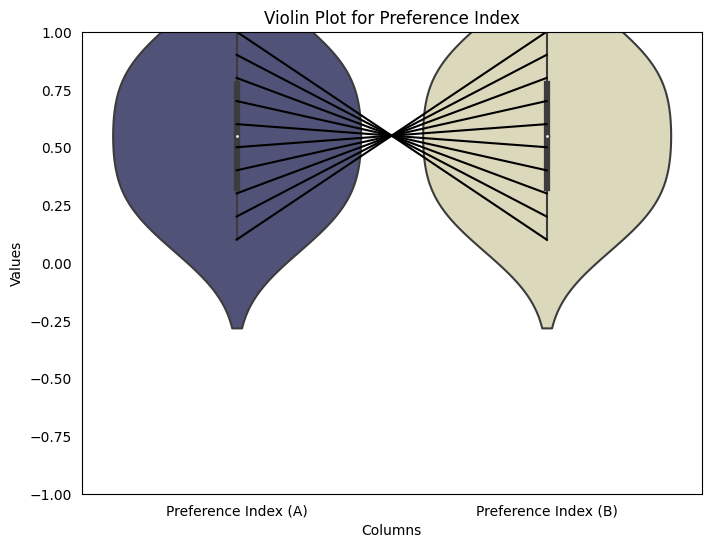

In [21]:
def combined_violins(df, column_list):
  """
  If you want to graph violinplots side-by-side use this definition
  df(pandas dataframe): this is typically the merged_df with all the subjects average metrics
  column_list (np array): this is a list of the columns you want plotted on the same chart (if the have (X) at the end, I subtracted the last 4 for title)
  filepath (str): where to save the graphs
  """
  plt.figure(figsize=(8, 6))
  sns.despine(left=True, bottom = True)
  plt.tick_params(left = False, bottom = False)
  sns.violinplot(x='variable', y='value', data=pd.melt(df[column_list]), palette = custom_palette2, inner = 'box')
  counter = 0
  for index, row in df.iterrows():
    sns.lineplot(x=[column_list[0], column_list[1]], y=row[[column_list[0], column_list[1]]], color = 'k')
  plt.ylim(-1,1) #change these to fit your violin plot
  plt.xlim(-.5,1.5) #change these to fit your violin plot
  plt.xlabel('Columns')
  plt.ylabel('Values')
  plt.title('Violin Plot for ' + column_list[0][:-4])
  #plt.savefig(os.path.join(filepath, 'Violin Plot for ' + column_list[0][:-4] + '.pdf'), transparent = True)
  plt.show()
data = {
    'Subject ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Average Velocity': [10, 12, 15, 18, 20, 22, 25, 28, 30, 32],
    'Average Acceleration': [5, 8, 10, 12, 15, 18, 20, 22, 25, 28],
    'Origin Distance': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5],
    'Total Distance Moved': [100, 120, 150, 180, 200, 220, 250, 280, 300, 320],
    'Total Transitions': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'A to B': [15, 18, 20, 22, 25, 28, 30, 32, 35, 38],
    'B to A': [10, 12, 15, 18, 20, 22, 25, 28, 30, 32],
    'Preference Index (A)': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'Preference Index (B)': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
    'Distance Moved (A)': [80, 85, 90, 95, 100, 105, 110, 115, 120, 125],
    'Distance Moved (B)': [125, 120, 115, 110, 105, 100, 95, 90, 85, 80],
    'Velocity (A)': [25, 28, 30, 32, 35, 38, 40, 42, 45, 48],
    'Velocity (B)': [48, 45, 42, 40, 38, 35, 32, 30, 28, 25],
    'Acceleration (A)': [15, 18, 20, 22, 25, 28, 30, 32, 35, 38],
    'Acceleration (B)': [38, 35, 32, 30, 28, 25, 22, 20, 18, 15],
    'Port Distance (A)': [30, 35, 40, 45, 50, 55, 60, 65, 70, 75],
    'Port Distance (B)': [75, 70, 65, 60, 55, 50, 45, 40, 35, 30]
}

df = pd.DataFrame(data)

columns_combined = ['Preference Index (A)', 'Preference Index (B)']

combined_violins(df, columns_combined)




#### WORKS IN THIS CONTEXT, BUT DOESNT IN LOOP

In [ ]:
df.rename(columns=lambda x: x.replace('(A)', '(Paired)').replace('(B)', '(Unpaired)'), inplace=True)

In [ ]:
np.random.seed(42)

# Generate a DataFrame with a 'frame' column and 10 randomly named columns
df = pd.DataFrame({
    'frame': range(1, 4501),
    **{str(i): np.random.rand(4500) for i in range(1, 11)}
})

# Display the DataFrame
print(df)

In [ ]:
np.random.seed(42)

# Generate a DataFrame with a 'frame' column and 10 columns representing preference indices
df = pd.DataFrame({
    'frame': range(1, 4455),
    **{str(i): np.random.uniform(-1, 1, 4454) for i in range(1, 11)}
})

# Display the DataFrame
print(df)

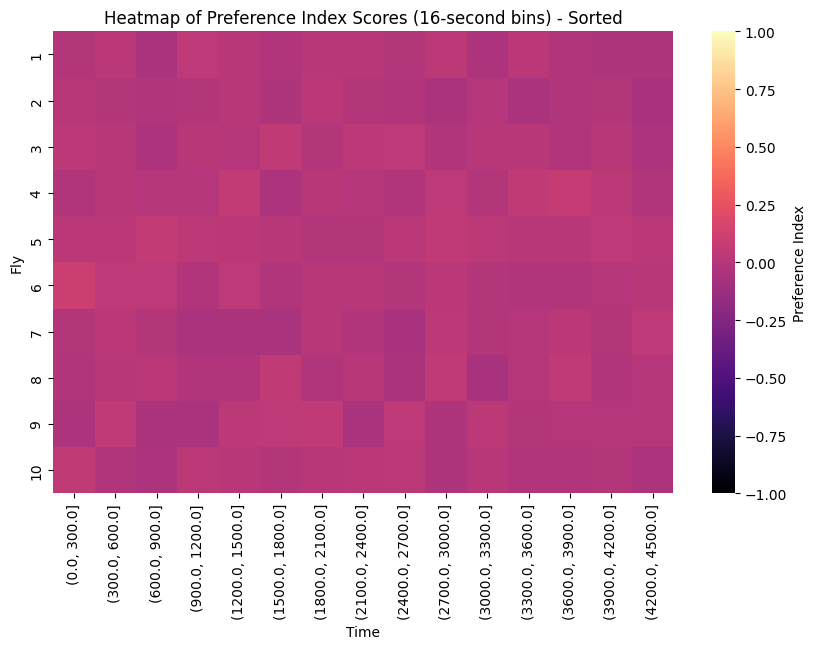

In [55]:
def heatmappy(df, bin_size = 16):
  """
  how to derive bin size, the lengths of these videos are about 4500, if you want 10 second bins the bin size has to be 4500/10 * FPS
  """
  binner = np.linspace(0, end_time, bin_size) # last number here is bin size where you wanna change
  #print(df)
  df['buckets'] = pd.cut(df['frame'], binner) #qcut>cut, because qcut is inclusive, or use -1

  tempdf = df.groupby(by='buckets').mean().drop(columns=['frame'])
  a = list(tempdf.columns.values)

  # Sort the DataFrame by mean preference index in descending order
  df_binned_sorted = tempdf.mean(axis=1).sort_values(ascending=False).index
  df_binned_sorted = tempdf.loc[df_binned_sorted]

  # Create a heatmap with row labels as column names

  plt.figure(figsize=(10, 6))
  sns.heatmap(tempdf.T, cmap='magma', cbar_kws={'label': 'Preference Index'}, center=0, vmin=-1, vmax=1)
  plt.xlabel('Time')
  plt.ylabel('Fly')
  #plt.axvline(x=310, color = 'k') #puts a vertical line where the stimulation is ~ 10 seconds in
  plt.title('Heatmap of Preference Index Scores ('+ str(bin_size) +'-second bins) - Sorted')
  #plt.savefig(os.path.join(filepath, side + ' Heatmap.pdf'), transparent = True)
  plt.show()


heatmappy(df)

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
# Example DataFrame (for demonstration purposes)
data = {
    'frame': range(1, 11),
    'Subject_1': ['A', 'B', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'B'],
    'Subject_2': ['B', 'A', 'B', 'A', 'A', 'B', 'A', 'B', 'A', 'A'],
    'Subject_3': ['A', 'A', 'B', 'B', 'A', 'A', 'B', 'A', 'B', 'B'],
    'Subject_4': ['A', 'A', 'A', 'B', 'A', 'B', 'A', 'A', 'B', 'B'],
    'Subject_5': ['B', 'A', 'B', 'B', 'A', 'A', 'B', 'A', 'A', 'A'],
    'Subject_6': ['B', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'A'],
    'Subject_7': ['A', 'B', 'B', 'A', 'A', 'A', 'B', 'A', 'B', 'B'],
    'Subject_8': ['B', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'A'],
    'Subject_9': ['A', 'B', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'A'],
    'Subject_10': ['A', 'B', 'A', 'B', 'B', 'A', 'A', 'B', 'A', 'B'],
}

df = pd.DataFrame(data)

# Count the number of 'A's and 'B's in each row
counts_A = df.iloc[:, 1:].apply(lambda row: row.eq('A').sum(), axis=1)
counts_B = df.iloc[:, 1:].apply(lambda row: row.eq('B').sum(), axis=1)

# Calculate the ratios
ratio_A = (counts_A - counts_B) / (counts_A + counts_B)
ratio_B = (counts_B - counts_A) / (counts_A + counts_B)

# Add the ratios to the DataFrame
df['Ratio_A'] = ratio_A
df['Ratio_B'] = ratio_B

# Display the DataFrame with ratios
print(df)

In [60]:
def ration (df):
  """
  This is the method that counts side A vs Side B overall to determine Preference Index
  """
  #sum the numbers of As and Bs for each row and generate a column of each
  counts_A = df.iloc[:, 1:].apply(lambda row: row.eq('A').sum(), axis=1)
  counts_B = df.iloc[:, 1:].apply(lambda row: row.eq('B').sum(), axis=1)
  #create a ration
  ratio_a = (counts_A - counts_B) / (counts_A + counts_B)
  ratio_b = (counts_B - counts_A) / (counts_A + counts_B)
  df['Ratio_A'] = ratio_A
  df['Ratio_B'] = ratio_B

  # Plot Ratio A
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(df['frame'], df['Ratio_A'], color='blue')
  plt.title('Ratio A')
  plt.xlabel('Frame')
  plt.ylabel('Ratio')

  # Plot Ratio B
  plt.subplot(1, 2, 2)
  plt.plot(df['frame'], df['Ratio_B'], color='red')
  plt.title('Ratio B')
  plt.xlabel('Frame')
  plt.ylabel('Ratio')

  plt.tight_layout()
  plt.show()
  return ratio_a, ratio_b
###from here you can just graph ration A or ratio B

SyntaxError: ignored

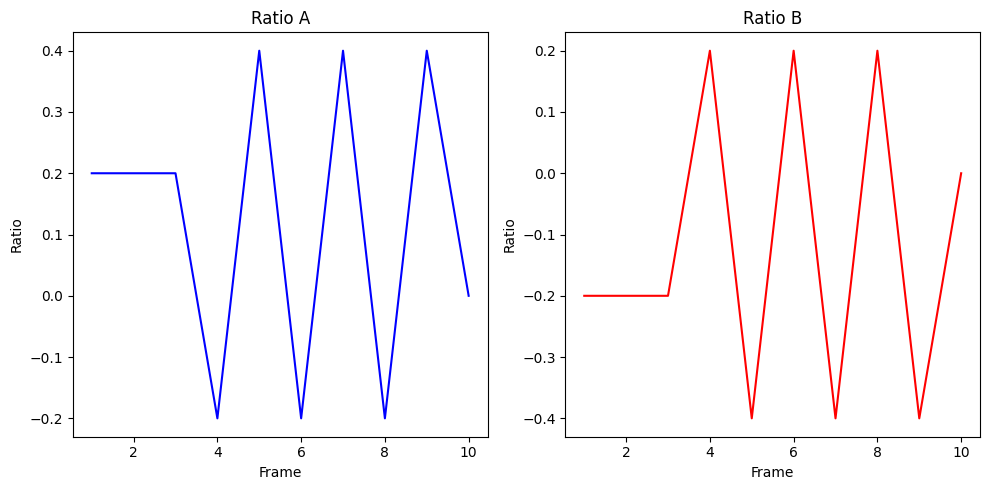

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 'Ratio_A' and 'Ratio_B' columns
# Example DataFrame (for demonstration purposes)
data = {
    'frame': range(1, 11),
    'Subject_1': ['A', 'B', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'B'],
    'Subject_2': ['B', 'A', 'B', 'A', 'A', 'B', 'A', 'B', 'A', 'A'],
    'Subject_3': ['A', 'A', 'B', 'B', 'A', 'A', 'B', 'A', 'B', 'B'],
    'Subject_4': ['A', 'A', 'A', 'B', 'A', 'B', 'A', 'A', 'B', 'B'],
    'Subject_5': ['B', 'A', 'B', 'B', 'A', 'A', 'B', 'A', 'A', 'A'],
    'Subject_6': ['B', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'A'],
    'Subject_7': ['A', 'B', 'B', 'A', 'A', 'A', 'B', 'A', 'B', 'B'],
    'Subject_8': ['B', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'A'],
    'Subject_9': ['A', 'B', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'A'],
    'Subject_10': ['A', 'B', 'A', 'B', 'B', 'A', 'A', 'B', 'A', 'B'],
}

df = pd.DataFrame(data)

# Count the number of 'A's and 'B's in each row
counts_A = df.iloc[:, 1:].apply(lambda row: row.eq('A').sum(), axis=1)
counts_B = df.iloc[:, 1:].apply(lambda row: row.eq('B').sum(), axis=1)

# Calculate the ratios
ratio_A = (counts_A - counts_B) / (counts_A + counts_B)
ratio_B = (counts_B - counts_A) / (counts_A + counts_B)

# Add the ratios to the DataFrame
df['Ratio_A'] = ratio_A
df['Ratio_B'] = ratio_B

# Plot Ratio A
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df['frame'], df['Ratio_A'], color='blue')
plt.title('Ratio A')
plt.xlabel('Frame')
plt.ylabel('Ratio')

# Plot Ratio B
plt.subplot(1, 2, 2)
plt.plot(df['frame'], df['Ratio_B'], color='red')
plt.title('Ratio B')
plt.xlabel('Frame')
plt.ylabel('Ratio')

plt.tight_layout()
plt.show()

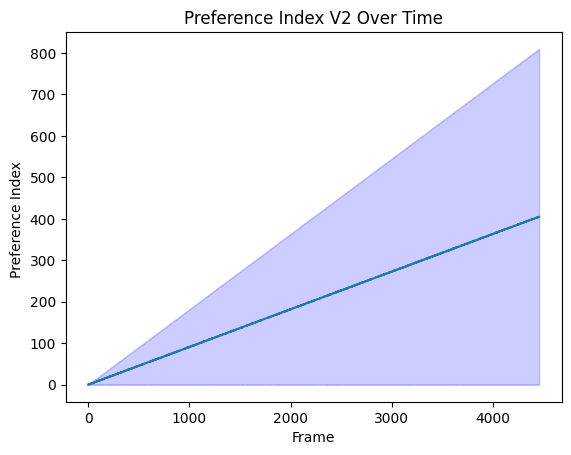

In [68]:
def average_pi_overtime(df):
  mean_pi_df = df.mean(axis = 1)
  sem_pi_df = df.sem(axis = 1)
  plt.plot(mean_pi_df, )
  plt.fill_between(df['frame'], mean_pi_df - sem_pi_df, mean_pi_df + sem_pi_df, alpha=0.2, color='blue')
  plt.title('Preference Index V2 Over Time')

  plt.xlabel('Frame')
  plt.ylabel('Preference Index ')

average_pi_overtime(df)